**Name:** Airyll Sanchez

**Date:** September 30,2025

## LABORATORY TASK # 6

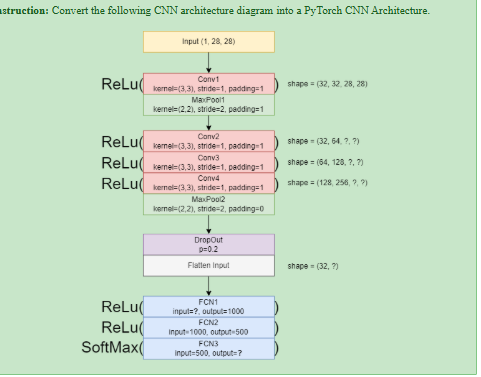

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import torch.optim as optim
import time

    SET SEED FOR REPRODUCIBILITY

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(143)

     GLOBAL CONSTANTS

In [4]:
OUTPUT_SIZE = 10 
BATCH_SIZE = 10   
EPOCHS = 5        
LEARNING_RATE = 0.001

     STEP 1: LOAD AND PREPARE MNIST DATASET

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_set, val_set = random_split(train_data, [48000, 12000])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaders prepared. Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Data Loaders prepared. Training batches: 4800, Validation batches: 1200


      STEP 2: DEFINE THE COSTUM CNN ARCHITECTURE

In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- CONVOLUTIONAL BLOCK 1 ---
        # Input: (1, 28, 28) -> Conv1 (32, 28, 28) -> Pool1 (32, 14, 14)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # --- CONVOLUTIONAL BLOCK 2 ---
        # Input: (32, 14, 14) -> ... -> Conv4 (256, 14, 14) -> Pool2 (256, 7, 7)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # --- LINEAR (FCN) BLOCK ---
        self.dropout = nn.Dropout(p=0.2)
        
        # Input to FCN1 = 256 * 7 * 7 = 12544
        self.fcn1 = nn.Linear(in_features=256 * 7 * 7, out_features=1000)
        self.fcn2 = nn.Linear(in_features=1000, out_features=500)
        self.fcn3 = nn.Linear(in_features=500, out_features=OUTPUT_SIZE)


    def forward(self, x):
        # Block 1
        x = self.pool1(F.relu(self.conv1(x)))
        
        # Block 2
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # FCN Block
        x = self.dropout(x) 
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        
        # Final output (logits)
        x = self.fcn3(x) 
        return x

        STEP 3: INSTANTIATE MODEL, CRITERION, & OPTIMIZER

In [7]:
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Check for CUDA and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nModel instantiated successfully. Using device: {device}")
print(f"Total Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Model instantiated successfully. Using device: cpu
Total Model Parameters: 13438350


         STEP 4: THE TRAINING LOOP

In [ ]:
start_time = time.time()
best_acc = 0.0
train_correct = []
train_losses = []
train_accs = []
val_correct = []
val_losses = []
val_accs = []
print("\nStarting Training...")

for e in range(EPOCHS):
    train_corr = 0
    val_corr = 0
    
    # --- TRAINING PHASE ---
    model.train() 
    # NOTE: tqdm is used here, ensure it's installed or remove 'tqdm()' 
    # if you encounter an error and cannot install it.
    for train_b, (x_train, y_train) in enumerate(train_loader):
        train_b += 1
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Forward Pass
        train_pred = model(x_train)
        train_loss = criterion(train_pred, y_train)

        # Calculate Correct Predictions
        train_pred_vec = torch.max(train_pred.data, 1)[1]
        train_corr += (train_pred_vec == y_train).sum()

        # Backward Pass & Parameter Update
        optimizer.zero_grad() 
        train_loss.backward() 
        optimizer.step()      

        # Log Batch Progress
        if train_b % (len(train_loader) // 4) == 0: # Print 4 times per epoch
            current_instances = train_b * BATCH_SIZE
            current_accuracy = (train_corr.item() / current_instances) * 100
            print(f"epoch: {e+1:2} | batch: {train_b:4} | instances: [{current_instances:6} / {len(train_loader) * BATCH_SIZE}] | loss: {train_loss.item():.4f}")
            print(f"✅ Correct: {train_corr.item()} | accuracy: {current_accuracy:.3f}%")

        train_correct.append(train_corr.item())
        train_losses.append(train_loss.item())

    # --- VALIDATION/EVALUATION PHASE ---
    model.eval() 
    with torch.no_grad(): 
        for val_b, (x_val, y_val) in enumerate(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            val_pred = model(x_val)
            val_pred_vec = torch.max(val_pred.data, 1)[1]
            val_corr += (val_pred_vec == y_val).sum()

            val_loss = criterion(val_pred, y_val)
            val_correct.append(val_corr.item())
            val_losses.append(val_loss.item())
            
        val_acc = val_corr.item() / (len(val_loader) * BATCH_SIZE)
        
        # Save best model logic (commented out the actual file saving for safety)
        if val_acc > best_acc:
            best_acc = val_acc
            # torch.save(model.state_dict(), f"model/best_CustomCNN.pth")
            print(f"\t📁New best model found! | Validation accuracy: {best_acc*100:.2f}%")
    
    # Store Epoch Accuracy
    train_epoch_acc = train_corr.item() / (BATCH_SIZE * len(train_loader))
    val_epoch_acc = val_corr.item() / (BATCH_SIZE * len(val_loader))
    
    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)
    
    print(f"--- Epoch {e+1} Complete: Train Acc={train_epoch_acc*100:.2f}%, Val Acc={val_epoch_acc*100:.2f}% ---")

print(f'\nTotal Duration: {time.time() - start_time:.0f} seconds')


Starting Training...
epoch:  1 | batch: 1200 | instances: [ 12000 / 48000] | loss: 0.0320
✅ Correct: 10710 | accuracy: 89.250%
